# Imports

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from torchviz import make_dot

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Common

In [43]:
def show_im(img):
    if len(img.shape) == 4:
        display(torchvision.transforms.ToPILImage()(img.squeeze(0)))
    elif len(img.shape) == 3:
        display(torchvision.transforms.ToPILImage()(img))
    else:
        raise ValueError("Image must be 3 or 4 dimensional")

In [32]:
transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(200, 200)),
    
])

# Rotation

In [33]:
def get_rot_mat(theta, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    zeros = torch.zeros_like(input=theta_cos).to(device)
    return torch.stack(tensors=[theta_cos, -theta_sin, zeros, theta_sin, theta_cos, zeros]).view(2,3)

def rot_img(x, theta, device):
    rot_mat = get_rot_mat(theta=theta, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=rot_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

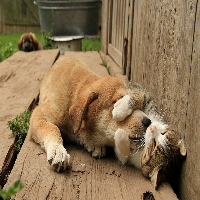

In [34]:
img = transform(torchvision.io.read_image("img/rgb/dog_cat.jpg")).to(device)
img.requires_grad = True
img = img.unsqueeze(dim=0)
show_im(img)

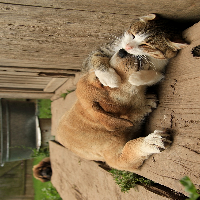

In [37]:
theta = torch.FloatTensor([np.pi/2]).to(device)   # 90 degrees
theta.requires_grad=True

rotated_img = rot_img(x=img, theta=theta, device=device) # Rotate image by theta = degree in radians
show_im(rotated_img)

In [39]:
loss = torch.mean((img - rotated_img)**2)
loss.backward()
theta.grad

tensor([-0.2185], device='cuda:0')

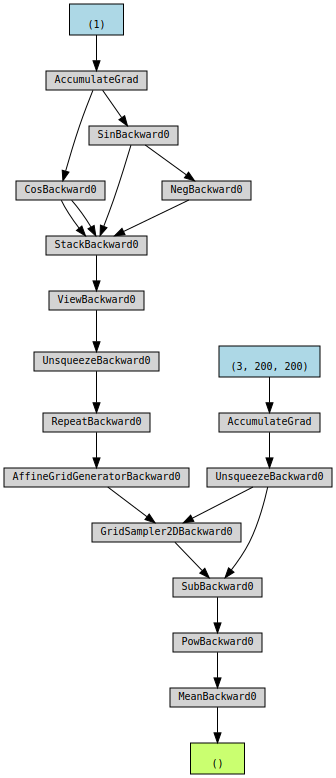

In [40]:
make_dot(loss)

# Scale

In [44]:
def get_scale_matrix(scale_factor, device):
    zeros = torch.zeros_like(input=scale_factor).to(device)
    return torch.stack(tensors=[scale_factor, zeros, zeros, zeros, scale_factor, zeros]).view(2,3)

def scale_img(x, scale_factor, device):
    scale_mat = get_scale_matrix(scale_factor=scale_factor, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

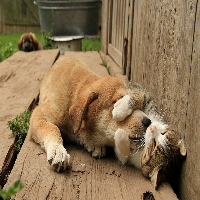

In [46]:
img = transform(torchvision.io.read_image("img/rgb/dog_cat.jpg")).to(device)
img.requires_grad = True
img = img.unsqueeze(dim=0)
show_im(img)

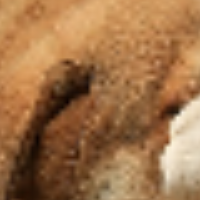

In [49]:
scale_factor = torch.FloatTensor([0.2]).to(device)  # <- 0.2 = 1/5 means 5 times bigger
scale_factor.requires_grad=True

#Scale by 0.3 with autograd support:
scaled_img = scale_img(x=img, scale_factor=scale_factor, device=device)
show_im(scaled_img)

In [50]:
loss = torch.mean((img - scaled_img)**2)
loss.backward()
scale_factor.grad

tensor([-0.0141], device='cuda:0')

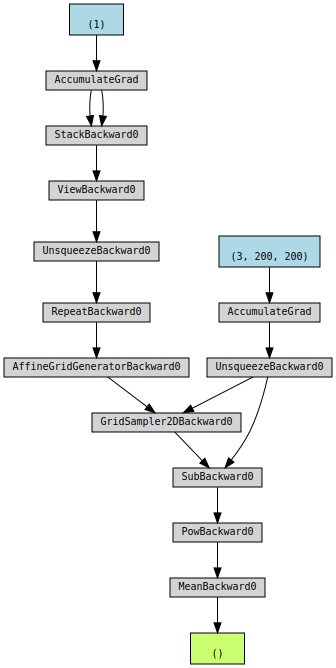

In [51]:
make_dot(loss)

# Translation

In [52]:
def get_translation_matrix(trans_x, trans_y, device):
    zeros = torch.zeros_like(input=trans_x).to(device)
    ones = torch.ones_like(input=trans_x).to(device)
    identical = torch.stack(tensors=[ones, zeros, trans_x, zeros, ones, trans_y]).view(2,3)
    return identical

def translate_img(x, trans_x, trans_y, device):
    translation_mat = get_translation_matrix(trans_x=trans_x, trans_y=trans_y, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=translation_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

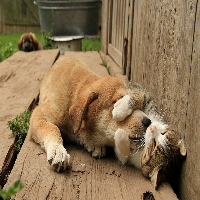

In [53]:
img = transform(torchvision.io.read_image("img/rgb/dog_cat.jpg")).to(device)
img.requires_grad = True
img = img.unsqueeze(dim=0)
show_im(img)

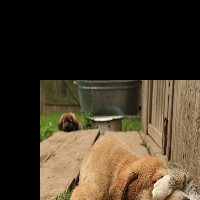

In [55]:
trans_X = torch.FloatTensor([2*-100/500]).to(device)    # <- -100 = move 100 pixels right
trans_X.requires_grad=True
trans_Y = torch.FloatTensor([2*-200/500]).to(device)    # <- -200 = move 200 pixels down
trans_Y.requires_grad=True

trans_img = translate_img(x=img.to(device), trans_x=trans_X, trans_y=trans_Y, device=device)
show_im(trans_img)

In [57]:
loss = torch.mean((img-trans_img)**2)
loss.backward()
trans_X.grad, trans_Y.grad

(tensor([-0.4271], device='cuda:0'), tensor([-0.2506], device='cuda:0'))

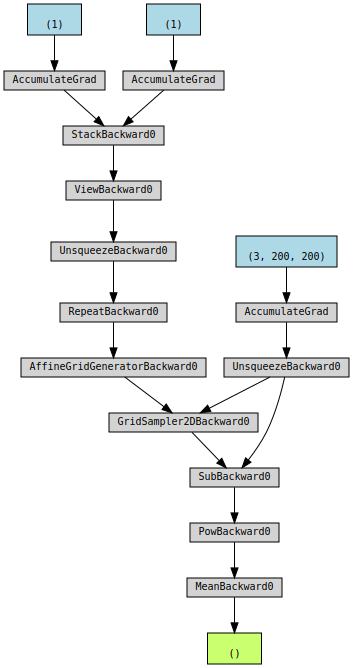

In [58]:
make_dot(loss)